In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson2D
problem = Poisson2D()

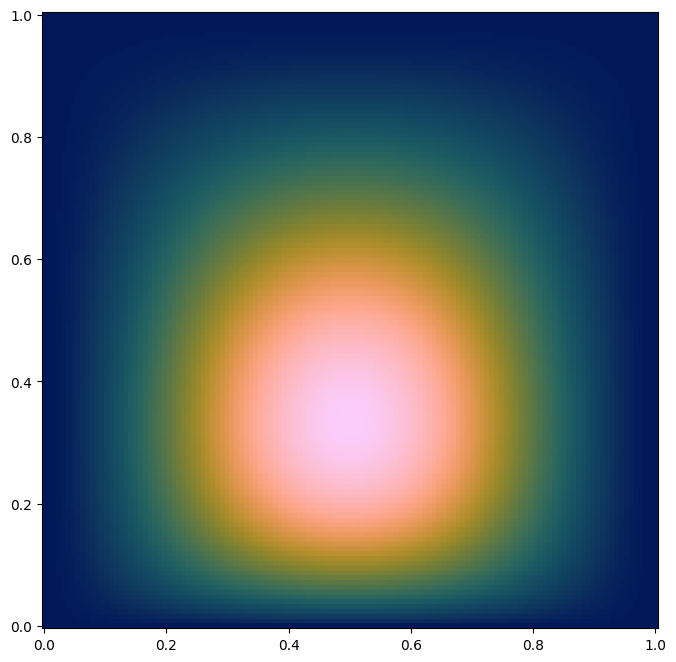

In [3]:
X, Y, u_solution = problem.exact_solution(nx=128, ny=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, Y, u_solution, cmap=cmap)

# Optimiser

In [4]:
class GeneralisedLevenbergMarquardt:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 1.5,
        increase_factor: float = 1.5,
        used_factor: float = 1.0,
        max_trials: int = 500,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.used_factor = used_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)

        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count = loop_val
            
            S_inv = S / (S**2 + trial_lambda)
            S_inv_final = jnp.where(S < 1e-5, 0.0, S_inv)
            
            delta = -Vt.T @ jnp.diag(S_inv_final) @ U.T @ residuals

            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = trial_loss < current_loss
            
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda / self.decrease_factor,
                lambda: trial_lambda * self.increase_factor
            )
            
            return new_lambda, accepted, trial_count + 1

        def continue_until_accepted(loop_val):
            # Continue if step is not accepted AND we haven't exceeded max trials
            _, accepted, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # --- Run the loop to find an acceptable step and lambda ---
        final_lambda, step_was_accepted, _ = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, (current_lambda, False, 0)
        )

        S_inv = S / (S**2 + (final_lambda * self.decrease_factor * self.used_factor))
        S_inv_final = jnp.where(S < 1e-5, 0.0, S_inv)


        final_delta = -Vt.T @ jnp.diag(S_inv_final) @ U.T @ residuals
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
        }

        return current_loss, updates, new_state, metrics


@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):#, boundary_pts, bc_weight):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [5]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
layer_sizes = [2, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)


aggr_optimiser = GeneralisedLevenbergMarquardt(
    decrease_factor=2.0,
    increase_factor=1.5,
    used_factor=0.8,
    init_lambda=1e-3,
)
aggr_opt_state = aggr_optimiser.init(params)
safe_optimiser = GeneralisedLevenbergMarquardt(
    decrease_factor=2.0,
    increase_factor=1.1,
    used_factor=1.0,
    init_lambda=1e-1,
)
safe_opt_state = safe_optimiser.init(params)


start_time = time.monotonic()

print(f"Starting PINN training with {type(aggr_optimiser).__name__}...")
for epoch in range(200):
    params, aggr_opt_state, loss_val, metrics = train_step(
        params, static, aggr_opt_state, aggr_optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


print(f"Starting PINN training with {type(safe_optimiser).__name__}...")
for epoch in range(50):
    params, safe_opt_state, loss_val, metrics = train_step(
        params, static, safe_opt_state, safe_optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with GeneralisedLevenbergMarquardt...
Epoch 20, Loss: 5.252e-01, Time elapsed: 19.46 s
Epoch 40, Loss: 2.911e-02, Time elapsed: 29.01 s
Epoch 60, Loss: 3.574e-03, Time elapsed: 38.70 s
Epoch 80, Loss: 5.955e-03, Time elapsed: 48.87 s
Epoch 100, Loss: 5.612e-05, Time elapsed: 59.27 s
Epoch 120, Loss: 8.239e-08, Time elapsed: 68.59 s
Epoch 140, Loss: 1.913e-07, Time elapsed: 78.08 s
Epoch 160, Loss: 5.230e-08, Time elapsed: 87.48 s
Epoch 180, Loss: 4.180e-07, Time elapsed: 96.88 s
Epoch 200, Loss: 1.183e-07, Time elapsed: 106.35 s
Starting PINN training with GeneralisedLevenbergMarquardt...
Epoch 5, Loss: 2.037e-12, Time elapsed: 113.04 s
Epoch 10, Loss: 1.895e-12, Time elapsed: 115.68 s
Epoch 15, Loss: 1.810e-12, Time elapsed: 120.62 s
Epoch 20, Loss: 1.810e-12, Time elapsed: 127.07 s
Epoch 25, Loss: 1.810e-12, Time elapsed: 133.38 s
Epoch 30, Loss: 1.810e-12, Time elapsed: 139.86 s
Epoch 35, Loss: 1.810e-12, Time elapsed: 146.52 s
Epoch 40, Loss: 1.810e-12, Time 

Relative L2 Error: 4.613e-06


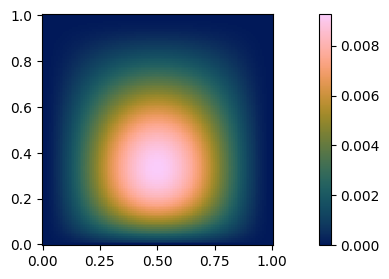

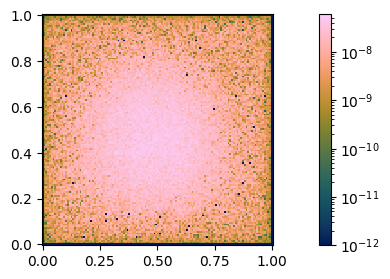

In [8]:
u_pred = model.predict(X, Y)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, Y, u_pred, cmap=cmap)
fig.colorbar(nn_solution, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, Y, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

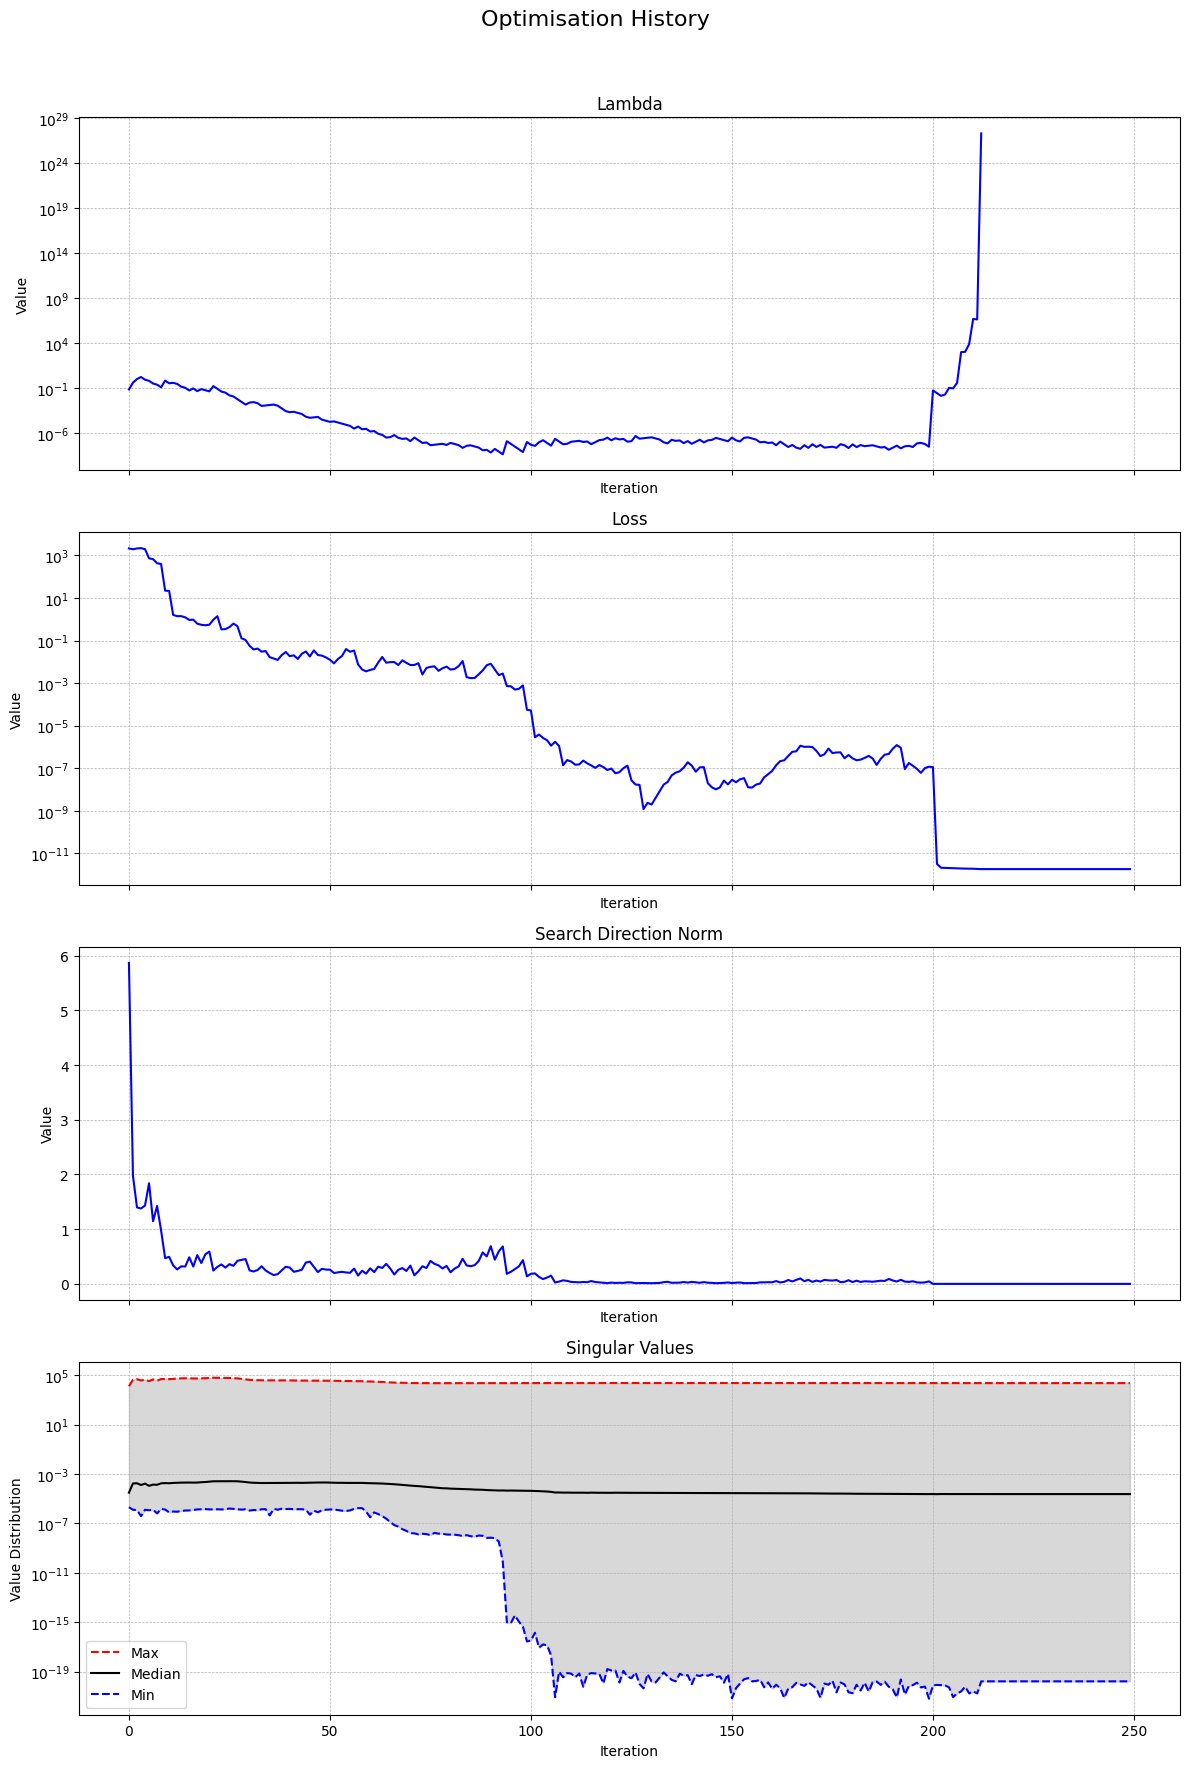

In [9]:
history.plot()